In [167]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import torch

In [168]:
kB = 0.0083144621
temperature = 300
biasFactor = 6.0
_deltaT = temperature*(biasFactor-1)

In [170]:
_totalBias = np.load("/home/armin/Documents/GADES/examples/AIB9/snrv_pd/biases/bias_1128172465_10001.npy")

In [171]:
FE = -((temperature+_deltaT)/_deltaT)*_totalBias

In [172]:
print(FE.min(), FE.max())

-88.49577107597396 -2.6590388893271362e-45


In [173]:
FE -= np.min(FE)

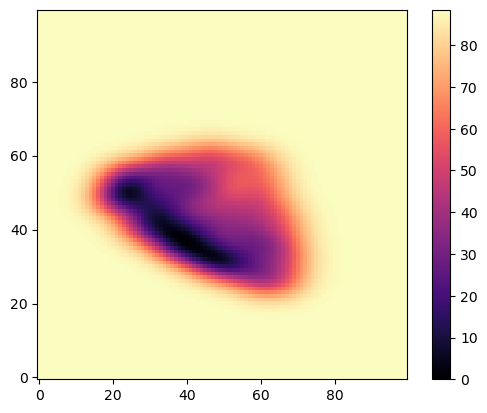

In [174]:
plt.imshow(FE, cmap='magma', norm='linear', aspect='equal', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

In [175]:
traj = md.load("traj_metad.dcd", top="../aib9.gro")
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [176]:
cv1 = torch.jit.load("cv1.pt")
cv2 = torch.jit.load("cv2.pt")

In [177]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in range(X.shape[0]):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

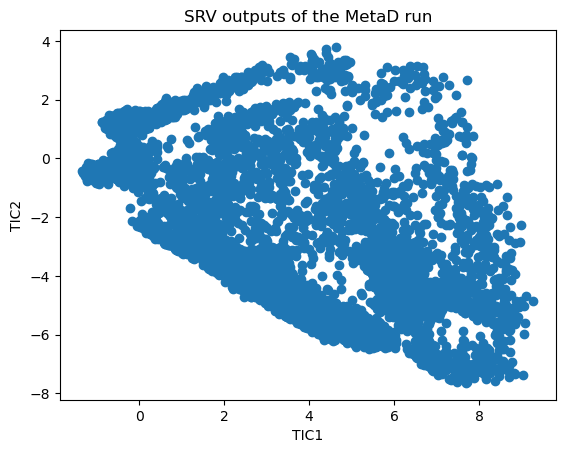

In [178]:
plt.scatter(cv1_vals, cv2_vals)
plt.ylabel("TIC2")
plt.xlabel("TIC1")
plt.title("SRV outputs of the MetaD run")
plt.show()

In [179]:
def get_colvars(traj):
    phi_atoms = [
    [4, 6, 8, 17],
    [17, 19, 21, 30],
    [30, 32, 34, 43],
    [43, 45, 47, 56],
    [56, 58, 60, 69],
    [69, 71, 73, 82],
    [82, 84, 86, 95],
    [95, 97, 99, 108],
    [108, 110, 112, 121]
]

    psi_atoms = [
        [6, 8, 17, 19],
        [19, 21, 30, 32],
        [32, 34, 43, 45],
        [45, 47, 56, 58],
        [58, 60, 69, 71],
        [71, 73, 82, 84],
        [84, 86, 95, 97],
        [97, 99, 108, 110],
        [110, 112, 121, 123]
    ]

    def compute_custom_phi_psi(traj, phi_atoms, psi_atoms):
        phi_vals = np.array([md.compute_dihedrals(traj, [atoms])[:, 0] for atoms in phi_atoms]).T
        psi_vals = np.array([md.compute_dihedrals(traj, [atoms])[:, 0] for atoms in psi_atoms]).T
        return phi_vals, psi_vals
    phi, psi = compute_custom_phi_psi(traj, phi_atoms, psi_atoms)
    CVs = np.stack([phi*180/np.pi, psi*180/np.pi], axis=1)
    kdes = []
    for i in range(CVs.shape[2]):
        # Compute 2D histogram
        counts, xedges, yedges = np.histogram2d(CVs[:, 0, i], CVs[:, 1, i], bins=100)

        # Assign count to each point’s bin
        xidx = np.searchsorted(xedges, CVs[:, 0, i]) - 1
        yidx = np.searchsorted(yedges, CVs[:, 1, i]) - 1

        # Clip indices to avoid out-of-bounds
        xidx = np.clip(xidx, 0, counts.shape[0] - 1)
        yidx = np.clip(yidx, 0, counts.shape[1] - 1)

        kdes.append(counts[xidx, yidx])
    return CVs, kdes

In [180]:
CVs, kdes = get_colvars(traj)

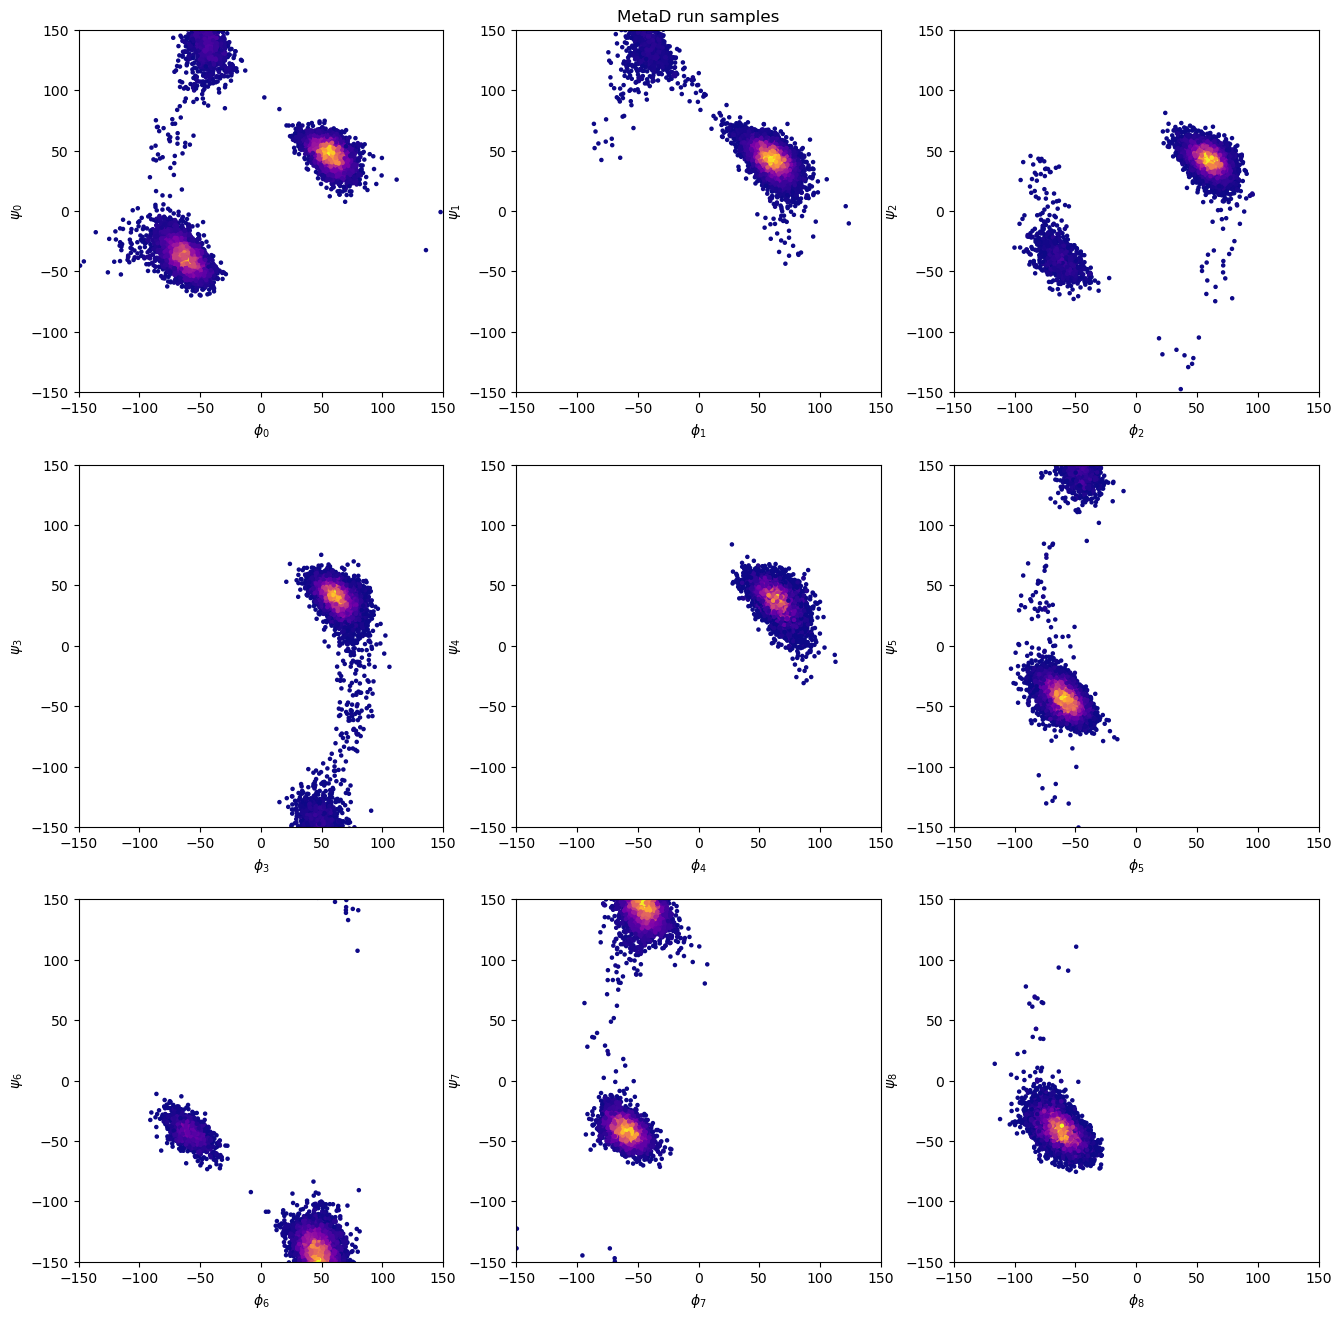

In [181]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for i in range(CVs.shape[2]):
    axs[i].scatter(CVs[:, 0, i], CVs[:, 1, i], c=kdes[i], cmap="plasma", s=5)
    axs[i].set_ylabel(fr"$\psi_{i}$")
    axs[i].set_xlabel(fr"$\phi_{i}$")
    axs[i].set_xlim(-150, 150)
    axs[i].set_ylim(-150, 150)
axs[1].set_title("MetaD run samples")
plt.show()

In [182]:
import numpy as np
import pandas as pd

def assign_weights_to_trajectory(bias: np.ndarray,
                                 x_vals: np.ndarray,
                                 y_vals:np.ndarray,
                                 min_x: float, max_x: float,
                                 min_y: float, max_y: float) -> pd.DataFrame:
    """
    Assigns weights from a 2D grid to each (x, y) point in a trajectory based on which grid cell the point falls into.

    Args:
        bias (np.ndarray): 2D array of shape (n_grid_x, n_grid_y) with bias on a regular grid.
        x_vals (np.ndarray): Array of shape (T, ).
        y_vals (np.ndarray): Array of shape (T, ).
        min_x (float): Minimum x value of the grid.
        max_x (float): Maximum x value of the grid.
        min_y (float): Minimum y value of the grid.
        max_y (float): Maximum y value of the grid.

    Returns:
        pd.DataFrame: DataFrame with columns ['x', 'y', 'weight'] for each timestep.
    """
    n_grid_x = bias.shape[0]
    n_grid_y = bias.shape[1]
    # Compute bin width
    dx = (max_x - min_x) / n_grid_x
    dy = (max_y - min_y) / n_grid_y

    # Map coordinates to indices
    ix = np.floor((x_vals - min_x) / dx).astype(int)
    iy = np.floor((y_vals - min_y) / dy).astype(int)

    # Clamp indices to valid range
    ix = np.clip(ix, 0, n_grid_x - 1)
    iy = np.clip(iy, 0, n_grid_y - 1)

    # Extract weights
    bias_vals = bias[ix, iy]
    weights = np.exp(bias_vals/temperature/kB)

    return pd.DataFrame({'CV1': x_vals, 'CV2': y_vals, 'bias': bias_vals, "weight": weights})

In [193]:
data_df = assign_weights_to_trajectory(_totalBias,
                                 cv1_vals.numpy(),
                                 cv2_vals.numpy(),
                                 -5, 15,
                                 -15, 15)

In [194]:
data_df.head()

,CV1,CV2,bias,weight
0,8.253688,-6.684122,0.296167,1.126072
1,8.494349,-7.153605,0.095192,1.038901
2,8.557584,-6.904007,0.095192,1.038901
3,8.081849,-6.548701,0.811777,1.384650
4,7.892442,-6.711795,1.353295,1.720382


In [199]:
def get_pmf(data_df, x, temperature, kB):
    # Histogram the weighted trajectory
    hist, x_edges = np.histogram(data_df[x],
                                 bins=50,
                                 weights=data_df['weight'])

    # Normalize to get probability density
    prob_density = hist / np.sum(hist)

    # Avoid log(0) by setting minimum positive value
    min_nonzero = np.min(prob_density[np.nonzero(prob_density)])
    prob_density[prob_density == 0] = min_nonzero

    # Convert to free energy
    fes = -kB * temperature * np.log(prob_density)

    # with np.errstate(divide='ignore'):  # Suppress warnings for log(0)
    #     fes = -kB * temperature * np.log(prob_density)
    # fes[np.isinf(fes)] = np.inf  # Optional but explicit

    # Optional: set minimum to zero
    fes -= np.min(fes)
    return fes, x_edges

def get_free_energy_surface(data_df, x, y, temperature, kB, range):
    # Histogram the weighted trajectory
    hist, x_edges, y_edges = np.histogram2d(data_df[x], data_df[y],
                                            bins=100,
                                            range=range,
                                            weights=data_df['weight'])

    # Normalize to get probability density
    prob_density = hist / np.sum(hist)

    # Avoid log(0) by setting minimum positive value
    min_nonzero = np.min(prob_density[np.nonzero(prob_density)])
    prob_density[prob_density == 0] = min_nonzero

    # Convert to free energy
    fes = -kB * temperature * np.log(prob_density)

    # with np.errstate(divide='ignore'):  # Suppress warnings for log(0)
    #     fes = -kB * temperature * np.log(prob_density)
    # fes[np.isinf(fes)] = np.inf  # Optional but explicit

    # Optional: set minimum to zero
    fes -= np.min(fes)
    return fes, x_edges, y_edges



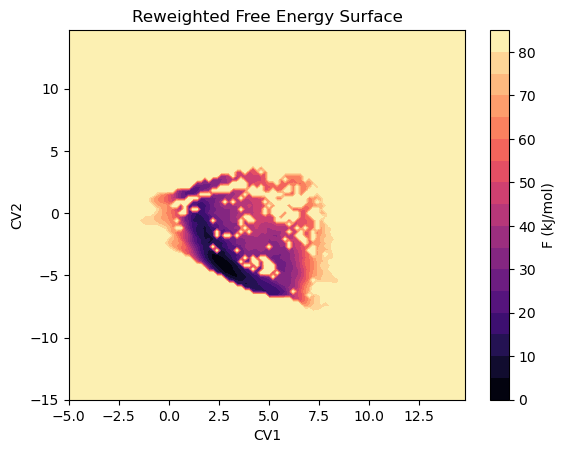

In [200]:
fes, x_edges, y_edges = get_free_energy_surface(data_df, "CV1", "CV2", temperature, kB, [[-5, 15], [-15, 15]])
plt.contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
plt.xlabel("CV1")
plt.ylabel("CV2")
plt.title("Reweighted Free Energy Surface")
plt.colorbar(label="F (kJ/mol)")
plt.show()

In [197]:
for i in range(CVs.shape[2]):
    data_df[f"phi{i}"] = CVs[:, 0, i]
    data_df[f"psi{i}"] = CVs[:, 1, i]

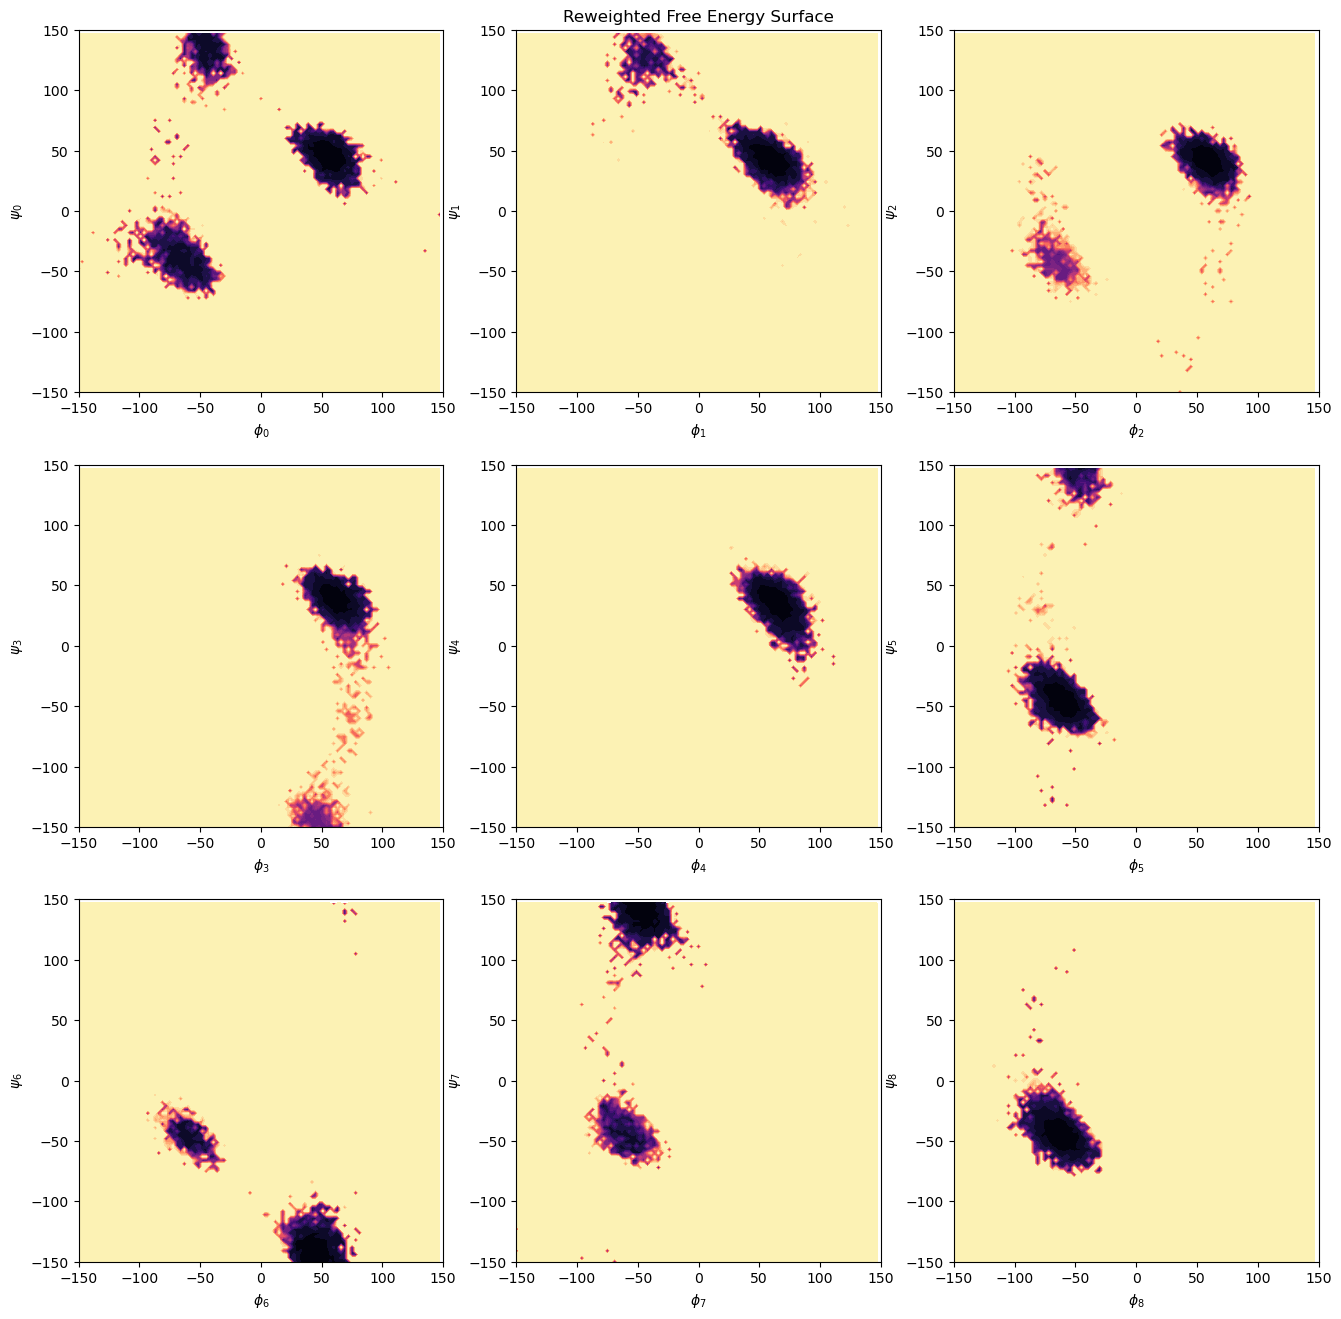

In [201]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for i in range(CVs.shape[2]):
    fes, x_edges, y_edges = get_free_energy_surface(data_df, f"phi{i}", f"psi{i}", temperature, kB, [[-150, 150], [-150, 150]])
    axs[i].contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
    axs[i].set_xlabel(fr"$\phi_{i}$")
    axs[i].set_ylabel(fr"$\psi_{i}$")
    axs[i].set_xlim(-150, 150)
    axs[i].set_ylim(-150, 150)
#plt.colorbar(label="F (kJ/mol)")
axs[1].set_title("Reweighted Free Energy Surface")
plt.show()


In [202]:
traj = md.load("traj_unbiased.dcd", top="../aib9.gro")

In [203]:
CVs, kdes = get_colvars(traj)

In [204]:
unbiased_df = pd.DataFrame({"weight": np.ones(CVs.shape[0], )})
for i in range(CVs.shape[2]):
    unbiased_df[f"phi{i}"] = CVs[:, 0, i]
    unbiased_df[f"psi{i}"] = CVs[:, 1, i]

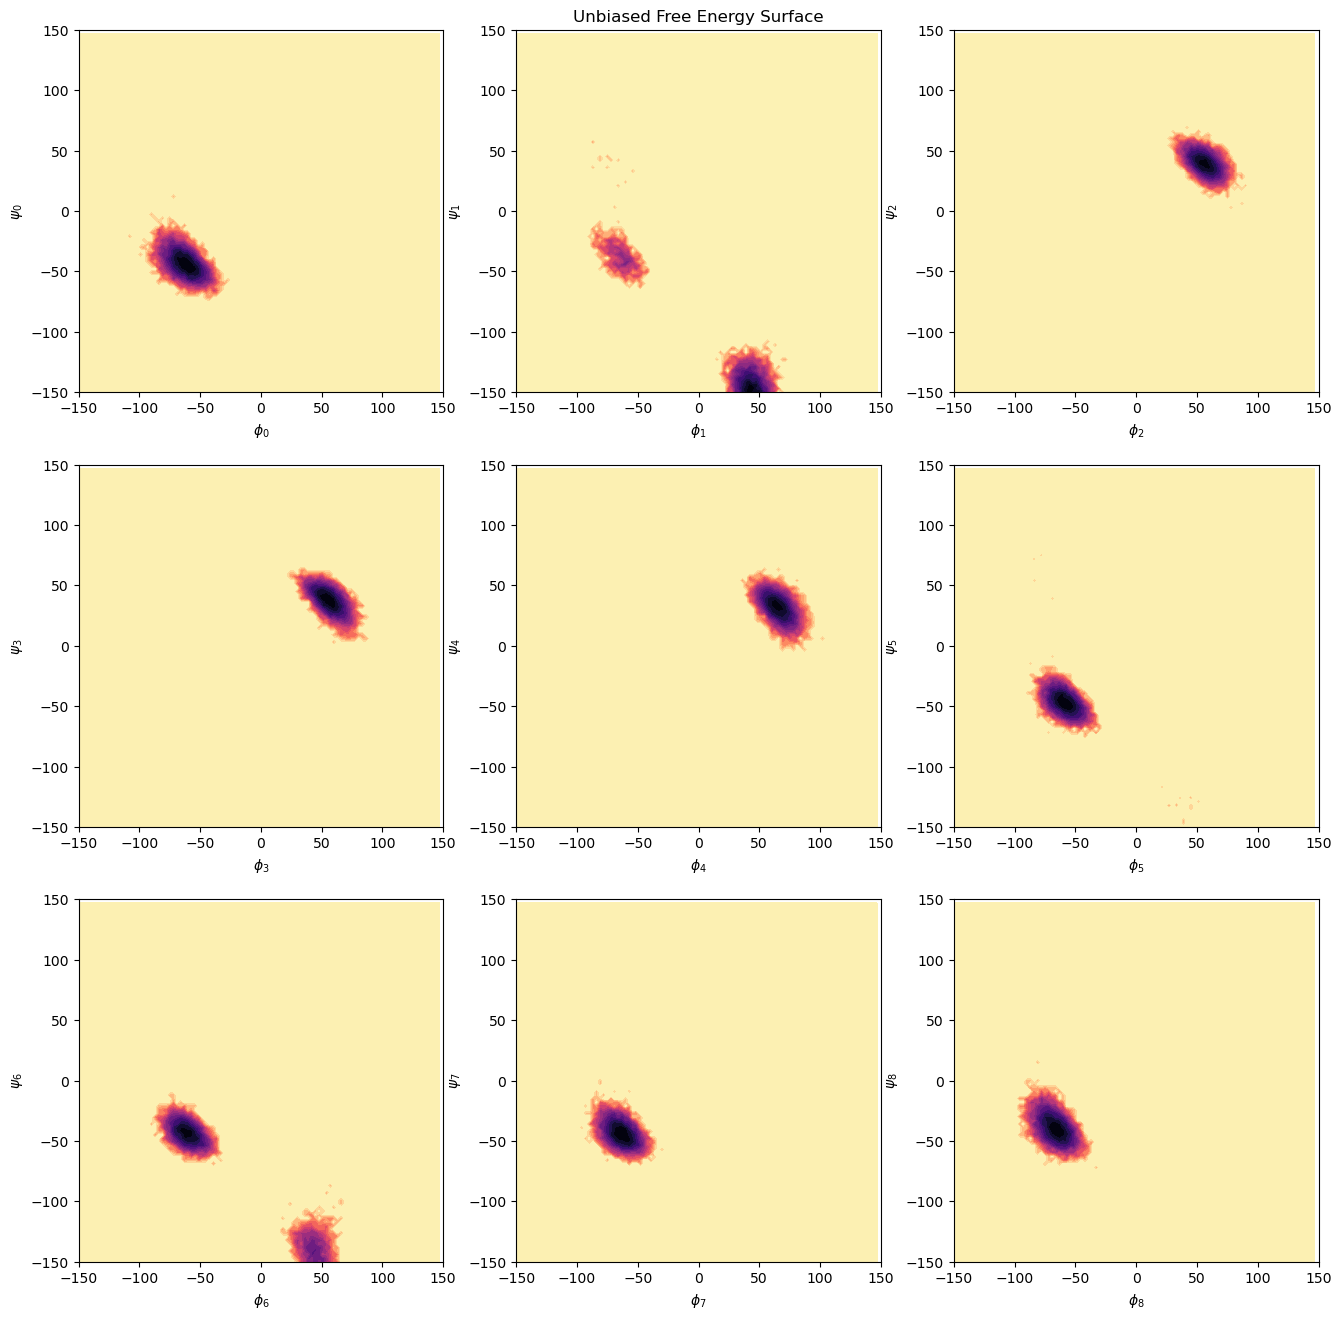

In [205]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for i in range(CVs.shape[2]):
    fes, x_edges, y_edges = get_free_energy_surface(unbiased_df, f"phi{i}", f"psi{i}", temperature, kB, [[-150, 150], [-150, 150]])
    axs[i].contourf(x_edges[:-1], y_edges[:-1], fes.T, levels=20, cmap='magma')
    axs[i].set_xlabel(fr"$\phi_{i}$")
    axs[i].set_ylabel(fr"$\psi_{i}$")
    axs[i].set_xlim(-150, 150)
    axs[i].set_ylim(-150, 150)
axs[1].set_title("Unbiased Free Energy Surface")
plt.show()

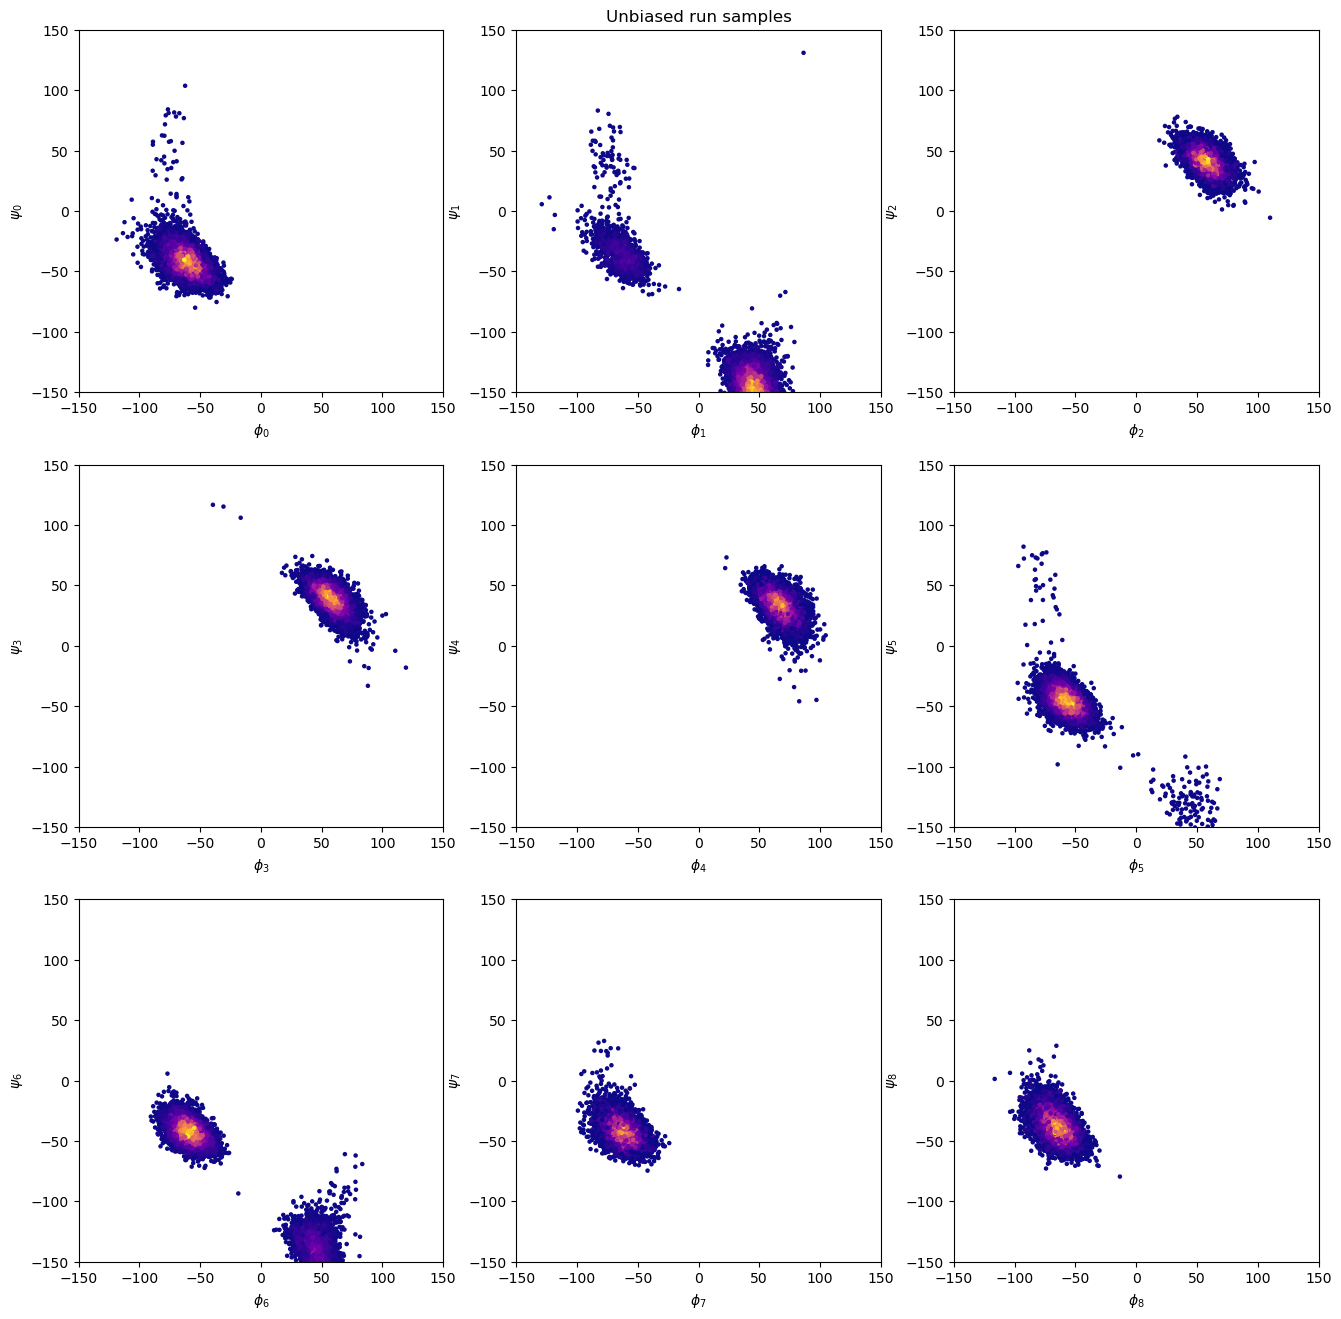

In [206]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for i in range(CVs.shape[2]):
    axs[i].scatter(CVs[:, 0, i], CVs[:, 1, i], c=kdes[i], cmap="plasma", s=5)
    axs[i].set_ylabel(fr"$\psi_{i}$")
    axs[i].set_xlabel(fr"$\phi_{i}$")
    axs[i].set_xlim(-150, 150)
    axs[i].set_ylim(-150, 150)
axs[1].set_title("Unbiased run samples")
plt.show()

In [207]:
traj = md.load("../traj_2000_2500.dcd", top="../aib9.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if atom.residue.name != 'HOH'])
X = torch.from_numpy(traj.xyz)
boxvectors = torch.from_numpy(traj.unitcell_vectors)

In [208]:
cv1_vals = torch.zeros(X.shape[0], )
cv2_vals = torch.zeros(X.shape[0], )
for i in range(X.shape[0]):
    with torch.no_grad():
        cv1_vals[i] = (cv1(X[i, ...], boxvectors[i, ...]))
        cv2_vals[i] = (cv2(X[i, ...], boxvectors[i, ...]))

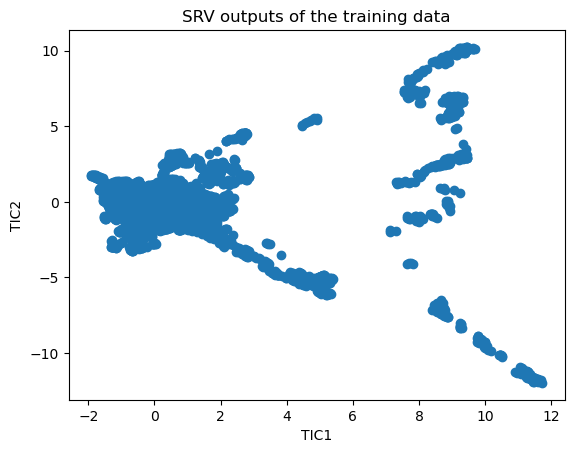

In [209]:
plt.scatter(cv1_vals, cv2_vals)
plt.xlabel("TIC1")
plt.ylabel("TIC2")
plt.title("SRV outputs of the training data")
plt.show()

In [210]:
CVs, kdes = get_colvars(traj)

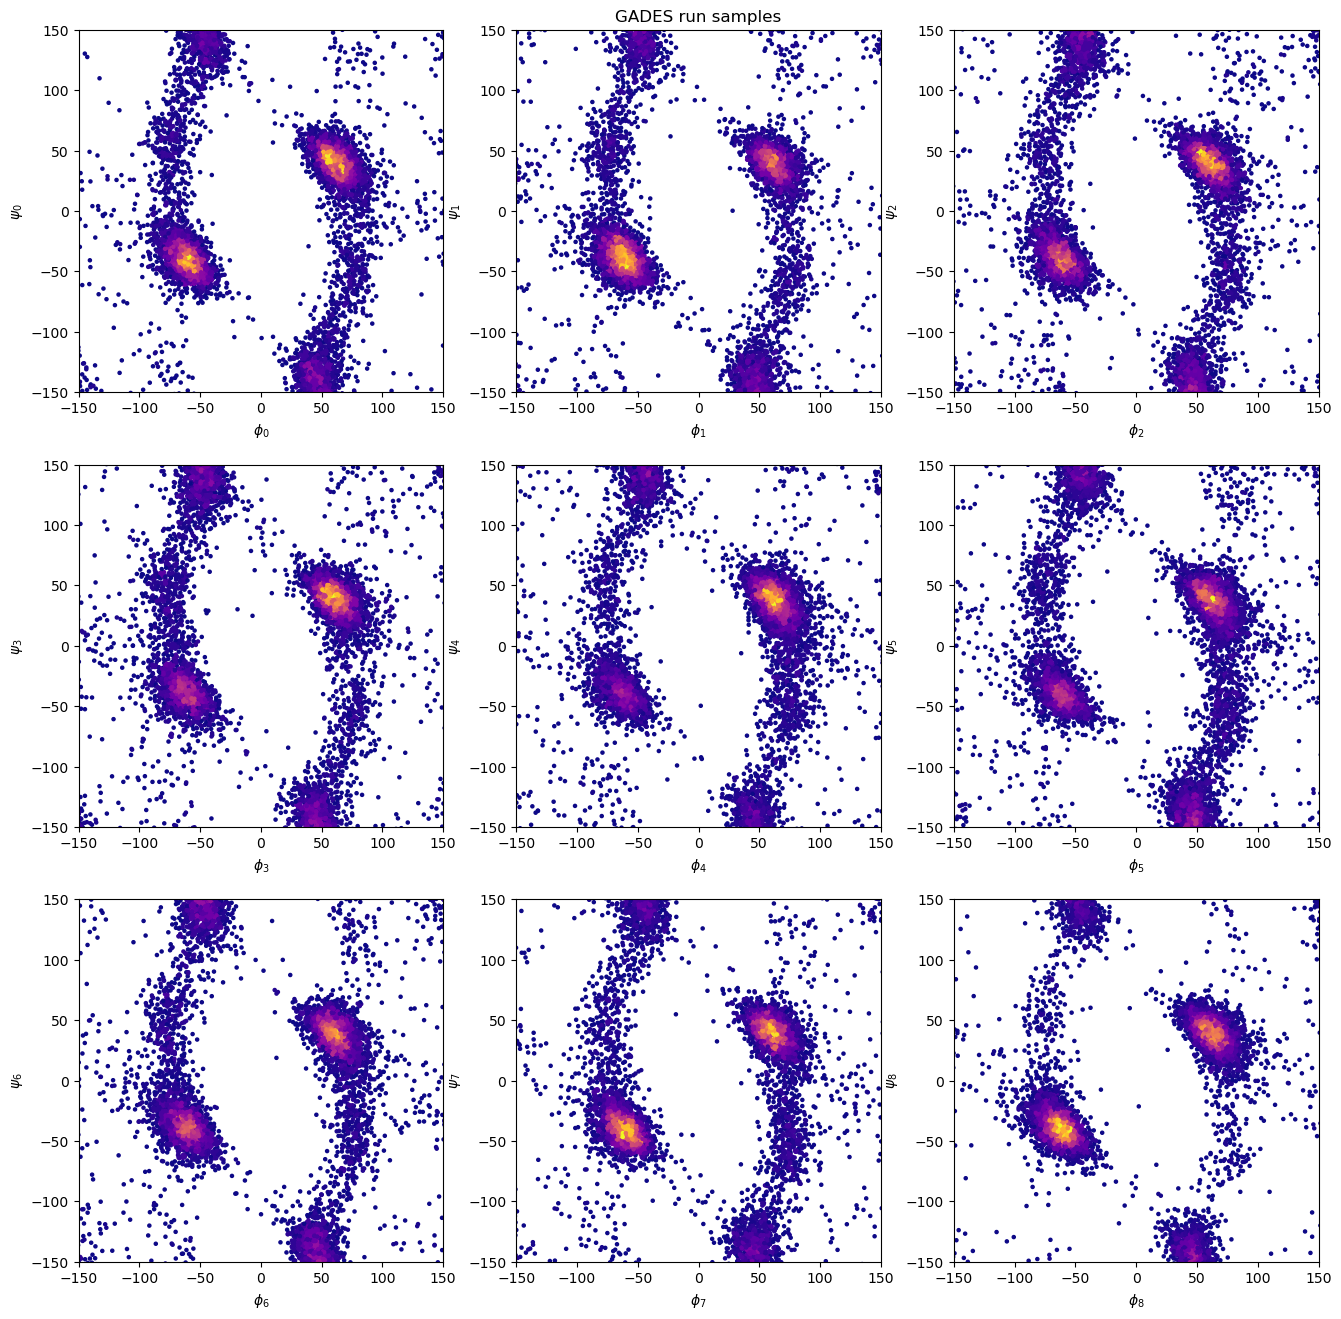

In [211]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
axs = axs.flatten()
for i in range(CVs.shape[2]):
    axs[i].scatter(CVs[:, 0, i], CVs[:, 1, i], c=kdes[i], cmap="plasma", s=5)
    axs[i].set_ylabel(fr"$\psi_{i}$")
    axs[i].set_xlabel(fr"$\phi_{i}$")
    axs[i].set_xlim(-150, 150)
    axs[i].set_ylim(-150, 150)
axs[1].set_title("GADES run samples")
plt.show()

See how GADES sees all the states, but MetaD doesn't. Because pairwise distances are not good enough for representing the system to the SRV.